# 講談社「Pythonではじめるベイズ機械学習入門」第3章 回帰モデル

## 3.1 線形単回帰モデル

In [1]:
using Distributions
using Plots

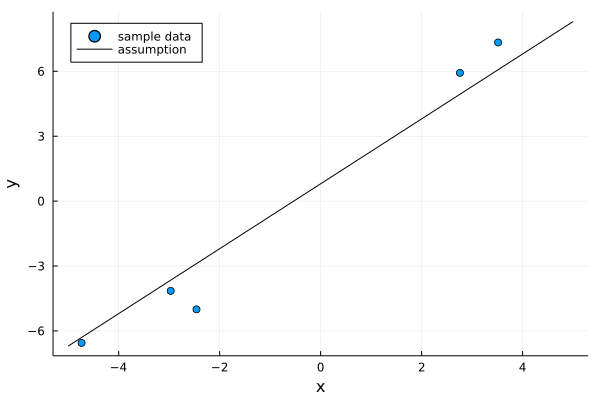

In [2]:
N = 5
true_w1 = 1.5
true_w2 = 0.8
x_data = rand(Uniform(-5, 5), N)
y_data = true_w1 .* x_data .+ true_w2 .+ rand(Normal(0, 1), N)

xs = -5:5
ys = true_w1 .* xs .+ true_w2
scatter(x_data, y_data, xlabel="x", ylabel="y", label="sample data", legend=:topleft)
plot!(xs, ys, color="black", label="assumption")

In [3]:
using Turing
using StatsPlots

In [4]:
@model function linear_regression(x, y)
    w1 ~ Normal(0.0, 10.0)
    w2 ~ Normal(0.0, 10.0)
    y ~ MvNormal(w1 * x .+ w2, 1.0)
    return y
end

model = linear_regression(x_data, y_data)

DynamicPPL.Model{var"###evaluator#306", (:x, :y), Tuple{Vector{Float64}, Vector{Float64}}, (), DynamicPPL.ModelGen{var"###generator#307", (:x, :y), (), Tuple{}}}(var"##evaluator#306", (x = [2.7595833157890395, -2.9690556176425886, -2.458160372304843, 3.5161762287615748, -4.734549268562304], y = [5.927110087958617, -4.150489746309069, -5.002646054644524, 7.332728655665241, -6.553793230047118]), DynamicPPL.ModelGen{var"###generator#307", (:x, :y), (), Tuple{}}(var"##generator#307", NamedTuple()))

In [5]:
chain = sample(model, NUTS(), 3000);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/akifumiabe/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


In [6]:
display(chain)

Object of type Chains, with data of type 2000×14×1 Array{Float64, 3}

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1
Samples per chain = 2000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = w1, w2

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters    mean     std  naive_se    mcse        ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ─────────  ──────
          w1  1.7680  0.1315    0.0029  0.0030  1681.0584  1.0000
          w2  0.8930  0.4663    0.0104  0.0091  1722.7609  0.9995

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
          w1  1.5212  1.6765  1.7662  1.8613  2.0290
          w2  0.0088  0.5734  0.8814  1.2123  1.7820


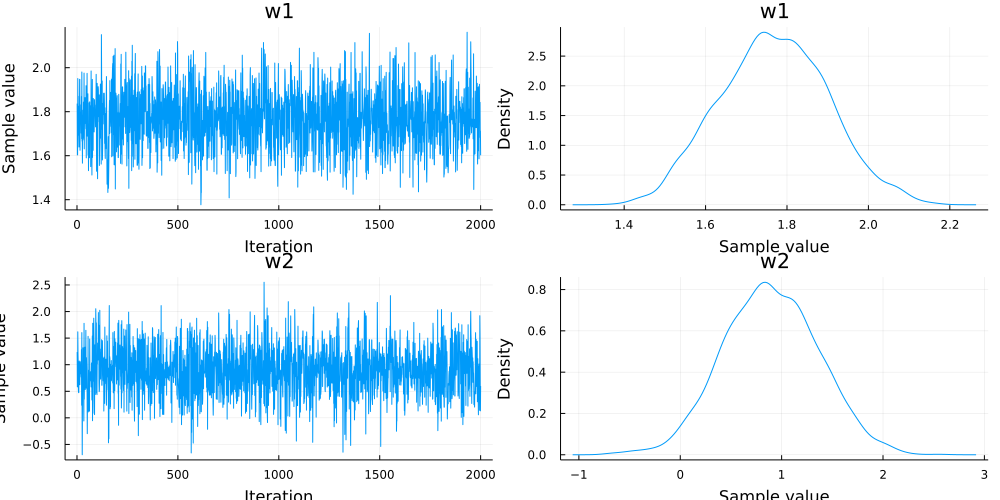

In [7]:
plot(chain)

In [8]:
describe(chain)

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters    mean     std  naive_se    mcse        ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ─────────  ──────
          w1  1.7680  0.1315    0.0029  0.0030  1681.0584  1.0000
          w2  0.8930  0.4663    0.0104  0.0091  1722.7609  0.9995

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
          w1  1.5212  1.6765  1.7662  1.8613  2.0290
          w2  0.0088  0.5734  0.8814  1.2123  1.7820


In [9]:
params = get_params(chain)
@show keys(params)

@show _, i = findmax(params[:lp])
@show params[:w1][i]
@show params[:w2][i];

keys(params) = (:hamiltonian_energy, :n_steps, :numerical_error, :max_hamiltonian_energy_error, :hamiltonian_energy_error, :is_accept, :w1, :tree_depth, :log_density, :step_size, :acceptance_rate, :w2, :lp, :nom_step_size)
(_, i) = findmax(params[:lp]) = (-12.742867716164477, CartesianIndex(1146, 1))
(params[:w1])[i] = 1.765430276788742
(params[:w2])[i] = 0.8867621875869713


In [10]:
function prediction(x, y;
        w1 = params[:w1],
        w2 = params[:w2],
        N = length(w1)
    )
    mean(pdf(Normal(w1[n] * x .+ w2[n], 1.0), y) for n in 1:N)
end

prediction(1.0, 1.0)

0.11930990464521243

  0.189565 seconds (689.63 k allocations: 38.236 MiB, 92.81% compilation time)


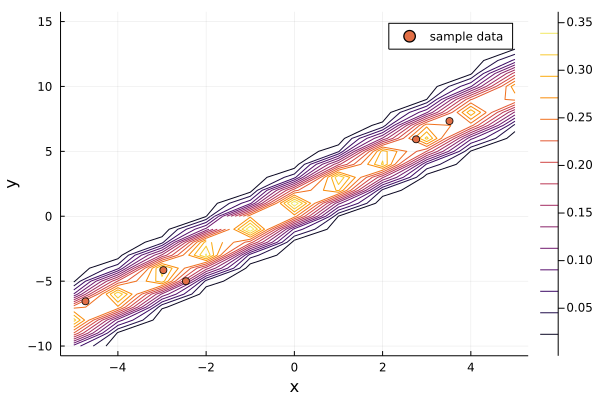

In [11]:
x_new = -5:5
y_new = -10:15
@time prob = prediction.(x_new', y_new)
contour(x_new, y_new, prob)
scatter!(x_data, y_data, xlabel="x", ylabel="y", label="sample data")

## 3.2 線形重回帰モデル

In [12]:
dim = 2
N = 4
true_w = [-1.5; 0.8; 1.2]
x_data = rand(Uniform(-5, 5), (N, dim))
bias = ones(N, 1)
x_data_add_bias = hcat(x_data, bias)
y_data = x_data_add_bias * true_w + rand(Normal(0.0, 1.0), (N, 1))
@show true_w
@show bias
@show x_data_add_bias
@show y_data
;

true_w = [-1.5, 0.8, 1.2]
bias = [1.0; 1.0; 1.0; 1.0;;]
x_data_add_bias = [-3.661505260686415 0.03688214254794264 1.0; 2.8610635604281622 -1.3914373816620742 1.0; -1.494815292493481 -4.014466403185511 1.0; -0.5934632516938603 -2.314345853062031 1.0]
y_data = [5.671614092741865; -5.9762175862507325; 0.1280755463292445; 1.3296219330006758;;]


In [13]:
@model function multi_linear_regression(x, y)
    N = size(x, 1)
    w1 ~ Normal(0, 10.0)
    w2 ~ Normal(0, 10.0)
    w3 ~ Normal(0, 10.0)
    for n in 1:N
        y[n] ~ Normal(w1 * x[n, 1] + w2 * x[n, 2] + w3 * x[n, 3], 1.0)
    end
    return y
end

model = multi_linear_regression(x_data_add_bias, y_data)

DynamicPPL.Model{var"###evaluator#337", (:x, :y), Tuple{Matrix{Float64}, Matrix{Float64}}, (), DynamicPPL.ModelGen{var"###generator#338", (:x, :y), (), Tuple{}}}(var"##evaluator#337", (x = [-3.661505260686415 0.03688214254794264 1.0; 2.8610635604281622 -1.3914373816620742 1.0; -1.494815292493481 -4.014466403185511 1.0; -0.5934632516938603 -2.314345853062031 1.0], y = [5.671614092741865; -5.9762175862507325; 0.1280755463292445; 1.3296219330006758;;]), DynamicPPL.ModelGen{var"###generator#338", (:x, :y), (), Tuple{}}(var"##generator#338", NamedTuple()))

In [14]:
chain = sample(model, NUTS(), 3000);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/akifumiabe/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


In [15]:
display(chain)

Object of type Chains, with data of type 2000×15×1 Array{Float64, 3}

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1
Samples per chain = 2000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = w1, w2, w3

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters     mean     std  naive_se    mcse        ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ─────────  ──────
          w1  -1.6864  0.2129    0.0048  0.0042  1428.1692  0.9998
          w2   0.3746  0.3375    0.0075  0.0075  1318.1646  1.0000
          w3  -0.2233  0.8554    0.0191  0.0186  1269.6403  0.9996

Quantiles
  parameters     2.5%    25.0%    50.0%    75.0%    97.5%
  ──────────  ───────  ───────  ───────  ───────  ───────
          w1  -2.0919  -1.8279  -1.6831  -1.5430  -1.2517
          w2  -0.2867   0

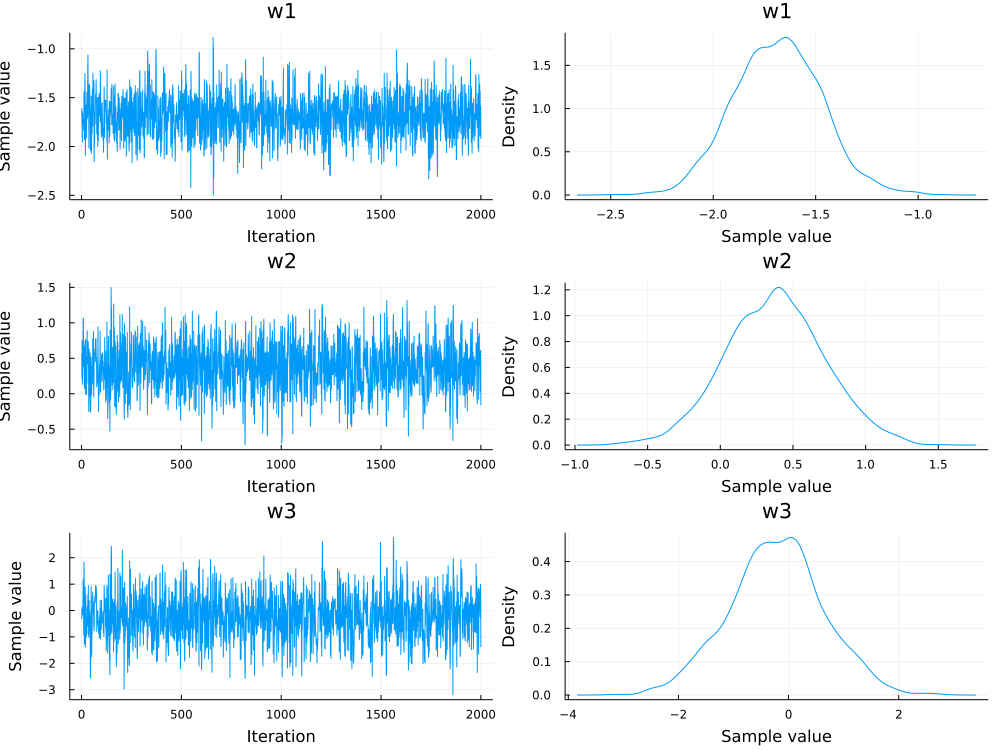

In [16]:
plot(chain)

In [17]:
describe(chain)

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters     mean     std  naive_se    mcse        ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ─────────  ──────
          w1  -1.6864  0.2129    0.0048  0.0042  1428.1692  0.9998
          w2   0.3746  0.3375    0.0075  0.0075  1318.1646  1.0000
          w3  -0.2233  0.8554    0.0191  0.0186  1269.6403  0.9996

Quantiles
  parameters     2.5%    25.0%    50.0%    75.0%    97.5%
  ──────────  ───────  ───────  ───────  ───────  ───────
          w1  -2.0919  -1.8279  -1.6831  -1.5430  -1.2517
          w2  -0.2867   0.1469   0.3833   0.5934   1.0414
          w3  -1.9217  -0.7675  -0.2211   0.3199   1.4273


In [18]:
params = get_params(chain)
@show keys(params)

@show _, i = findmax(params[:lp])
@show params[:w1][i]
@show params[:w2][i]
@show params[:w3][i];

keys(params) = (:w3, :hamiltonian_energy, :n_steps, :numerical_error, :max_hamiltonian_energy_error, :hamiltonian_energy_error, :is_accept, :w1, :tree_depth, :log_density, :step_size, :acceptance_rate, :w2, :lp, :nom_step_size)
(_, i) = findmax(params[:lp]) = (-14.716810047672334, CartesianIndex(1961, 1))
(params[:w1])[i] = -1.6992394749594852
(params[:w2])[i] = 0.38754248576262795
(params[:w3])[i] = -0.15207234783640128


In [19]:
xs = range(-5, 5, length=10)
x1 = repeat(xs, inner=(length(xs))) # xsの個々の要素を、xsの要素数の回数分、繰り返す
x2 = repeat(xs, outer=(length(xs))) # xs全体を、xsの要素数の回数分、繰り返す
x_new = hcat(x1, x2)
bias = ones(size(x_new, 1))
x_new_add_bias = hcat(x_new, bias)

100×3 Matrix{Float64}:
 -5.0      -5.0       1.0
 -5.0      -3.88889   1.0
 -5.0      -2.77778   1.0
 -5.0      -1.66667   1.0
 -5.0      -0.555556  1.0
 -5.0       0.555556  1.0
 -5.0       1.66667   1.0
 -5.0       2.77778   1.0
 -5.0       3.88889   1.0
 -5.0       5.0       1.0
 -3.88889  -5.0       1.0
 -3.88889  -3.88889   1.0
 -3.88889  -2.77778   1.0
  ⋮                   
  3.88889   3.88889   1.0
  3.88889   5.0       1.0
  5.0      -5.0       1.0
  5.0      -3.88889   1.0
  5.0      -2.77778   1.0
  5.0      -1.66667   1.0
  5.0      -0.555556  1.0
  5.0       0.555556  1.0
  5.0       1.66667   1.0
  5.0       2.77778   1.0
  5.0       3.88889   1.0
  5.0       5.0       1.0

In [20]:
function prediction(x; 
        w1 = params[:w1],
        w2 = params[:w1],
        w3 = params[:w1],
        N = size(x, 1),
        L = length(w1)
    )
    ypred = zeros(N, L)
    for j in 1:L
        for i in 1:N
            ypred[i, j] = w1[j] * x[i, 1] + w2[j] * x[i, 2] + w3[j] * x[i, 3]
        end
    end
    return ypred
end

ypred = prediction(x_new_add_bias)

100×2000 Matrix{Float64}:
  14.4924     15.8842     14.7636    …   14.7962     14.3024     17.3037
  12.7032     13.9232     12.941         12.9695     12.5367     15.1674
  10.914      11.9621     11.1183        11.1428     10.771      13.0312
   9.12483    10.0011      9.29563        9.31614     9.00523    10.8949
   7.33564     8.04013     7.47296        7.48945     7.2395      8.75867
   5.54646     6.07912     5.65029   …    5.66275     5.47377     6.62241
   3.75728     4.11812     3.82761        3.83606     3.70804     4.48615
   1.9681      2.15711     2.00494        2.00936     1.9423      2.34989
   0.178918    0.196101    0.182267       0.182669    0.176573    0.213626
  -1.61026    -1.76491    -1.64041       -1.64403    -1.58916    -1.92263
  12.7032     13.9232     12.941     …   12.9695     12.5367     15.1674
  10.914      11.9621     11.1183        11.1428     10.771      13.0312
   9.12483    10.0011      9.29563        9.31614     9.00523    10.8949
   ⋮              

In [21]:
function ypred_quantile(ypred, percentile;
        N = size(ypred, 1),
        L = length(percentile)
    )
    q_ypred = zeros(N, L)
    for j in 1:L
        for i in 1:N
            q_ypred[i, j] = quantile(ypred[i, :], percentile[j])
        end
    end
    return q_ypred
end

percentile = [0.1, 0.25, 0.5, 0.75, 0.9]
q_ypred = ypred_quantile(ypred, percentile)

100×5 Matrix{Float64}:
  12.8288    13.8872     15.1482     16.4515     17.5625
  11.245     12.1727     13.278      14.4205     15.3943
   9.6612    10.4583     11.4079     12.3894     13.2261
   8.0774     8.7438      9.53772    10.3584     11.0579
   6.49359    7.02933     7.66758     8.32731     8.88965
   4.90979    5.31486     5.79744     6.29626     6.72144
   3.32599    3.60039     3.9273      4.26521     4.55324
   1.74218    1.88592     2.05716     2.23416     2.38503
   0.15838    0.171447    0.187014    0.203105    0.216821
  -1.95139   -1.82795    -1.68313    -1.54302    -1.42542
  11.245     12.1727     13.278      14.4205     15.3943
   9.6612    10.4583     11.4079     12.3894     13.2261
   8.0774     8.7438      9.53772    10.3584     11.0579
   ⋮                                            
 -17.1288   -16.0453    -14.7741    -13.5443    -12.512
 -19.297    -18.0764    -16.6443    -15.2588    -14.0958
  -1.95139   -1.82795    -1.68313    -1.54302    -1.42542
  -4.1195

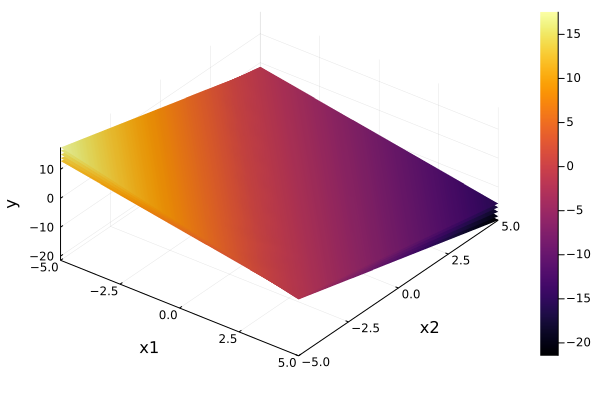

In [22]:
function visualize_3D(x1, x2, q_ypred;
        L = size(q_ypred, 2)
    )
    p1 = plot(xlabel="x1", ylabel="x2", zlabel="y")
    for i in 1:L
        p1 = surface!(x1, x2, q_ypred[:, i], camera=(40,70)) 
    end
    return p1
end

p1 = visualize_3D(x1, x2, q_ypred)